<a href="https://colab.research.google.com/github/HaitianLiu/mbi_CV_proj/blob/main/GAN_aug_cv_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, GlobalAvgPool2D, Dense, Add, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from IPython.display import Image, display

# shush warnings
import logging
import tensorflow as tf

# Set logging level to only show errors
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Filter out warnings related to while_loop conversions
tf.get_logger().setLevel("ERROR")

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils

import zipfile
import scipy.io

from tensorflow import keras
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
# Miscellaneous
from tqdm import tqdm
import os
import pandas as pd
import random
from collections import Counter
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!gdown "https://drive.google.com/uc?id=1BNQdJotVpohNrJ-j-JG1F5LSPAjY7mo2"
!ls -l

Downloading...
From: https://drive.google.com/uc?id=1BNQdJotVpohNrJ-j-JG1F5LSPAjY7mo2
To: /content/archive.zip
100% 156M/156M [00:00<00:00, 256MB/s]
total 152160
-rw-r--r-- 1 root root 155791278 May 14 04:06 archive.zip
drwxr-xr-x 2 root root      4096 May 14 04:00 models
drwxr-xr-x 1 root root      4096 May 11 16:35 sample_data
drwxr-xr-x 6 root root      4096 May 14 02:29 Testing
drwxr-xr-x 6 root root      4096 May 14 02:29 Training


In [ ]:
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    # Extract all files from the archive
    zip_ref.extractall()

In [ ]:
train_dir = '/content/Training/'
test_dir = '/content/Testing/'

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
train_paths[:5]

['/content/Training/pituitary/Tr-pi_0761.jpg',
 '/content/Training/notumor/Tr-no_1417.jpg',
 '/content/Training/pituitary/Tr-pi_0474.jpg',
 '/content/Training/pituitary/Tr-pi_1357.jpg',
 '/content/Training/glioma/Tr-gl_0229.jpg']

In [ ]:
Counter(test_labels).keys()

dict_keys(['meningioma', 'notumor', 'pituitary', 'glioma'])

In [ ]:
Counter(test_labels).values()

dict_values([306, 405, 300, 300])

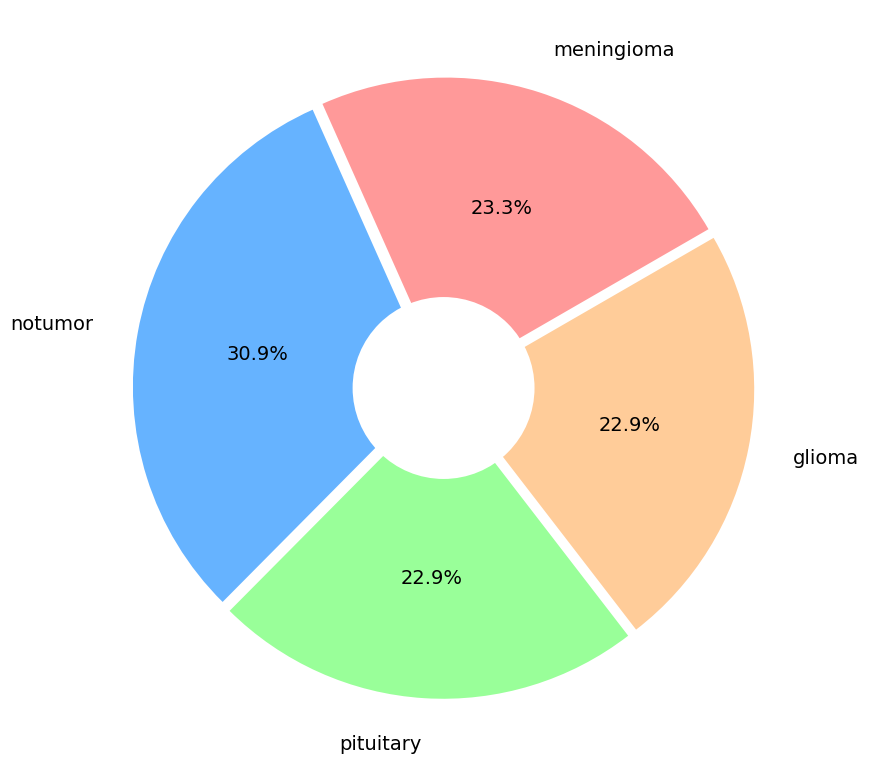

In [ ]:
plt.figure(figsize=(10,8))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.rcParams.update({'font.size': 14})
plt.pie(Counter(test_labels).values(), labels=Counter(test_labels).keys(),
         autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025), labeldistance=1.15, colors = colors,
        startangle=30)
centre_circle = plt.Circle((0,0),0.30,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# plt.title("Distribution of labels of brain tumor", y = 1.05, fontsize = 18)
plt.tight_layout()

# Data Argumentation

In [ ]:
# random augment of imput
resize_dim = (128,128)
def augment_image(image, resize_dim):
    # image = Image.fromarray(np.uint8(image))
    # # image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    # # image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    # image = np.array(image)/255.0
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.resize(image, resize_dim)
    image.set_shape(resize_dim + (3,))
    return image

In [ ]:
IMAGE_SIZE = 128
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image, resize_dim)
        images.append(image)
    return np.array(images)

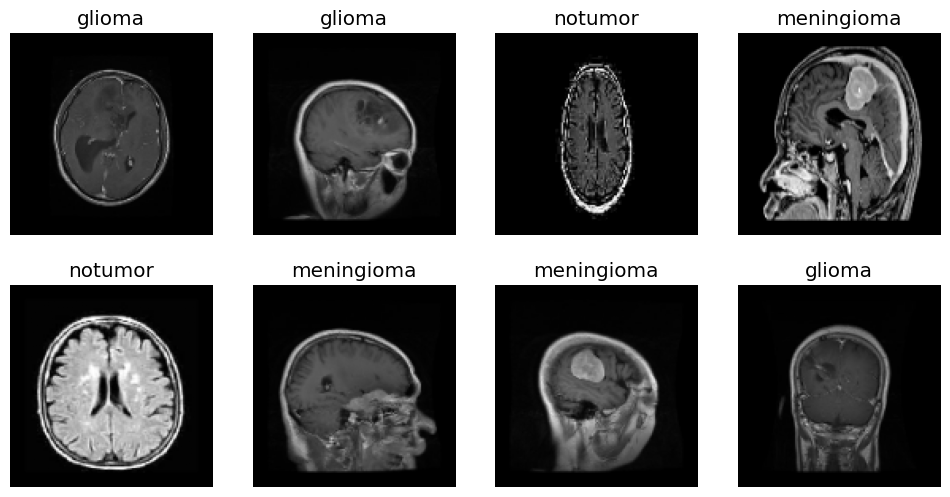

In [ ]:
images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
X_train = open_images(train_paths)
X_train.shape

(5712, 128, 128, 3)

In [ ]:
X_test = open_images(test_paths)
X_test.shape

(1311, 128, 128, 3)

In [ ]:
labels = sorted(set(train_labels))
print(labels)
label2idx = {l: i for i, l in enumerate(labels)}
idx2label = {i: l for i, l in enumerate(labels)}

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
y_train = np.array([label2idx[label] for label in train_labels]).ravel()
y_test = np.array([label2idx[label] for label in test_labels]).ravel()

In [ ]:
# Split off 20% of train data for validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=109)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4569, 128, 128, 3), (1143, 128, 128, 3), (4569,), (1143,))

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import time

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import tensorflow_datasets as tfds
plt.gray()

<Figure size 640x480 with 0 Axes>

In [ ]:
# DO NOT DELETE THIS CELL
# Global variables to define training/loading models.
TRAIN = True
EPOCHS = 5  # number of epochs to train models
BATCH_SIZE = 64
INPUT_SIZE = (128, 128, 3)  # images will be cropped and resized to `input_size`.

In [ ]:
def make_generator(input_dim, latent_dim, leaky_alpha=0.2, init_stddev=0.02):
    flat_dim = latent_dim[0]*latent_dim[1]*latent_dim[2]
    init_rn = initializers.RandomNormal(stddev=init_stddev)

    model = models.Sequential()
    model.add(layers.Dense(flat_dim, kernel_initializer=init_rn, input_shape=input_dim))
    model.add(layers.LeakyReLU(leaky_alpha))
    model.add(layers.Reshape(latent_dim))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(128,(4,4),strides=(1,1),padding='same', use_bias=False, kernel_initializer=init_rn))
    model.add(layers.LeakyReLU(leaky_alpha))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(128,(4,4),strides=(1,1),padding='same', use_bias=False, kernel_initializer=init_rn))
    model.add(layers.LeakyReLU(leaky_alpha))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(3,(4,4),strides=(1,1),padding='same',
                            use_bias=False, kernel_initializer=init_rn, activation='sigmoid'))

    g_opt = optimizers.Adam(2e-4, beta_1=0.5)
    g_loss = losses.BinaryCrossentropy(from_logits=True)

    model.compile(loss=g_loss, optimizer=g_opt)
    model.summary()

    return model, g_opt, g_loss


noise_dim = (128,)
leaky_alpha = 0.2
input_dim = (128,128,3)
latent_dim = (8,8,256)

gen, g_opt, g_loss = make_generator(noise_dim, latent_dim, leaky_alpha)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             2113536   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       524288    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                      

In [ ]:
def make_discriminator(input_dim, leaky_alpha=0.3, init_stddev=0.02):
    init_rn = initializers.RandomNormal(stddev=init_stddev)

    model = models.Sequential()
    model.add(layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init_rn, input_shape=input_dim))
    model.add(layers.LeakyReLU(leaky_alpha))
    model.add(layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init_rn))
    model.add(layers.LeakyReLU(leaky_alpha))

    model.add(layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init_rn))
    model.add(layers.LeakyReLU(leaky_alpha))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    d_opt = optimizers.Adam(2e-4, beta_1=0.5)
    d_loss = losses.BinaryCrossentropy(from_logits=True)

    model.compile(loss=d_loss, optimizer=d_opt)
    model.summary()

    return model, d_opt, d_loss

disc, d_opt, d_loss = make_discriminator(input_dim, leaky_alpha)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 flatten_1 (Flatten)         (None, 65536)            

In [ ]:
@tf.function
def training_step(img_batch, true_labels, fake_labels):
    """
    Use tf.GradientTape to train both the generator and discriminator on
    a batch of images. Calculate the losses and then apply the gradients
    to each optimizer to update the weights.

    Parameters:
        img_batch : single batch of images from a tf.data.DataSet pipeline
        real_labels : vector of labels for real images
        fake_labels : vector of labels for fake images

    Returns:
        None
    """

    noise = tf.random.normal([img_batch.shape[0], noise_dim[0]])

    # Train the discriminator
    with tf.GradientTape() as d_tape:
        # Generate fake images from the latent vector
        gen_images = gen(noise, training=True)

        # Get the logits for both fake and real images
        real_logits = disc(img_batch, training=True)
        fake_logits = disc(gen_images, training=True)

        # Calculate the discriminator loss using both fake and real logits
        real_loss = d_loss(true_labels, real_logits)
        fake_loss = d_loss(fake_labels, fake_logits)
        discriminator_loss = real_loss + fake_loss

    # Train the generator
    with tf.GradientTape() as g_tape:
        gen_images = gen(noise, training=True)
        fake_logits = disc(gen_images, training=True)
        generator_loss = g_loss(true_labels, fake_logits)

    # Get gradients and apply to the generator optimizer
    g_gradients = g_tape.gradient(generator_loss, gen.trainable_variables)
    g_opt.apply_gradients(zip(g_gradients, gen.trainable_variables))

    # Get and apply gradients for the discriminator optimizer
    d_gradients = d_tape.gradient(discriminator_loss, disc.trainable_variables)
    d_opt.apply_gradients(zip(d_gradients, disc.trainable_variables))

In [ ]:
SEED = tf.random.normal([BATCH_SIZE, noise_dim[0]])
EPOCHS = 5
CHECKPOINT_PATH = os.path.join('models', 'trained_GAN')
CHECKPOINT = tf.train.Checkpoint(gen=gen, disc=disc, g_opt=g_opt, d_opt=d_opt)
TRAIN = True

# Define some helper functions
def show_images(imgs):
    """
    Generate a plot of images.
    """
    n_imgs = imgs.shape[0]

    fig, ax = plt.subplots(1, n_imgs, figsize=(15, 20))
    plt.axis('off')
    for i in range(n_imgs):
        ax[i].imshow(np.clip(imgs[i], 0.0, 1.0))
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

def train_GAN(dataset, epochs, img_seed, checkpoint_path, checkpoint, num_images=8):

    for epoch in range(epochs):
        start = time.time()
        print('-'*30)
        print(f'Training Epoch: {epoch}')

        for img_batch in dataset.take(0):
            # Create soft labels
            true_labels = np.random.uniform(0.7, 1.2, (img_batch.shape[0], 1))
            fake_labels = np.random.uniform(0.0, 0.3, (img_batch.shape[0], 1))

            # Pass the image batch and labels to our training function
            training_step(img_batch, true_labels, fake_labels)

        test_images = gen(img_seed[:num_images], training=False)
        show_images(test_images)

        checkpoint.save(checkpoint_path)

        print(f'Time to Complete: {time.time()-start}')

In [ ]:
def plot_image(tf_data, n_images):
    fig, axes = plt.subplots(
        1, n_images, figsize=(16,3)
    )

    plt.suptitle(
        'Random Sample of Images from train_ds',
        fontsize=18
    )
    for elements in tf_data.take(1):
        for (i, ax) in enumerate(axes):
            ax.imshow(elements[i].numpy())
            ax.set_axis_off()
        pass
    plt.show()

In [ ]:
datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
      # customize these and other parameters
      rotation_range=15,
      width_shift_range=1,
      height_shift_range=1,
      shear_range= 5,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest',
)

In [ ]:
X_train2 = X_train.copy()
X_train_more = X_train.copy()
y_train_more = y_train.copy()
# datagen_aug.fit(X_train2)

# for i in range(10):
#     for x_batch, y_batch in datagen_aug.flow(X_train2, y_train, batch_size=128):
#         X_train_more = np.append(X_train_more, x_batch.reshape(128, 128, 128, 3), axis = 0)
#         y_train_more = np.append(y_train_more, y_batch)
#         break
X_train_more.shape, y_train_more.shape

((4569, 128, 128, 3), (4569,))

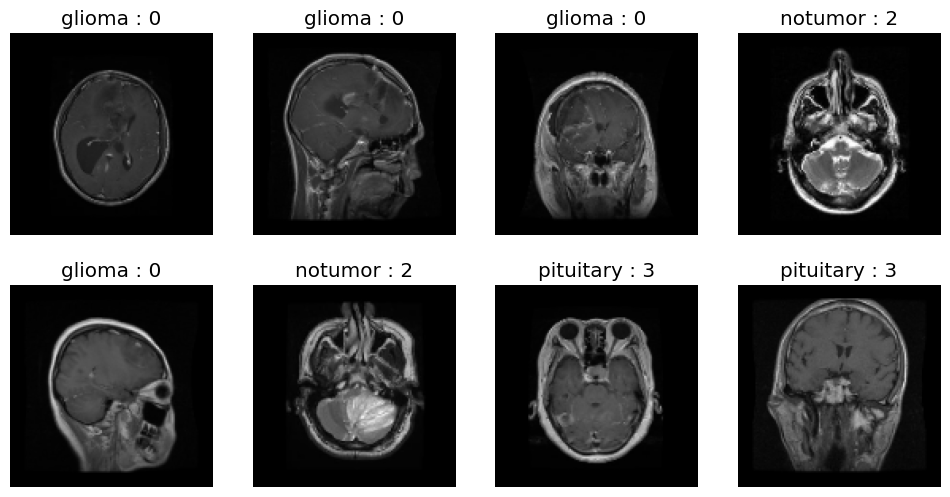

In [ ]:
# plot argumnetation data
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(f'{idx2label[y_train_more[x+2000]]} : {y_train_more[x+2000]}')
    plt.imshow(X_train_more[x+2000])
plt.rcParams.update({'font.size': 12})
plt.show()

# Dataset pipline

In [ ]:
def dataset_pipline(x):
    dataset = tf.data.Dataset.from_tensor_slices((x))
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.batch(batch_size = 128)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
dataset_train = dataset_pipline(X_train_more)
dataset_val = dataset_pipline(X_val)
dataset_test = dataset_pipline(X_test)

In [ ]:
# dataset_train = dataset_pipline(X_train_more,y_train_more)
# dataset_val = dataset_pipline(X_val,y_val)
# dataset_test = dataset_pipline(X_test,y_test)

In [ ]:
# tf.data.Dataset.save(dataset_train, "dataset/train")
# tf.data.Dataset.save(dataset_val, "dataset/val")
# tf.data.Dataset.save(dataset_test, "dataset/test")

------------------------------
Training Epoch: 0


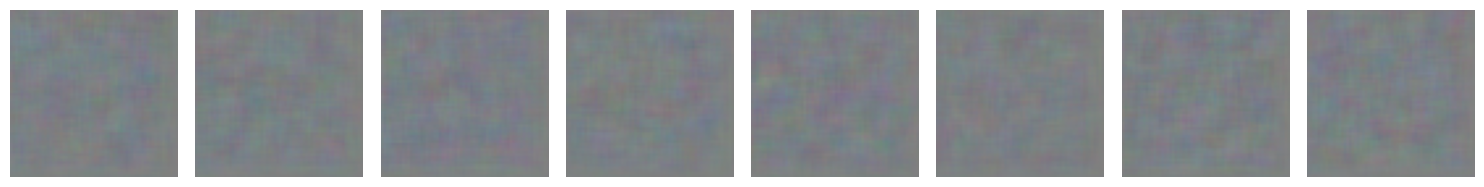

Time to Complete: 1.1348655223846436
------------------------------
Training Epoch: 1


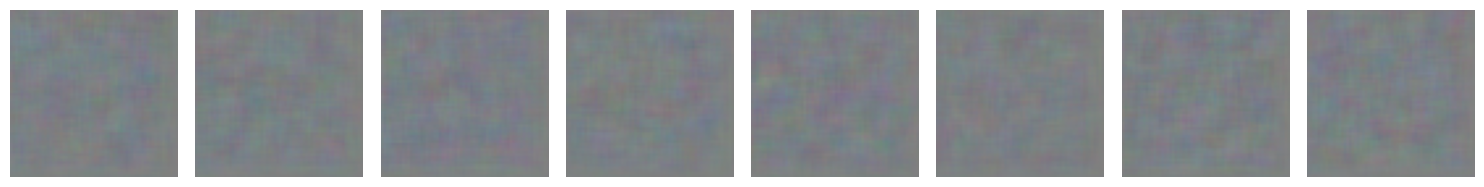

Time to Complete: 1.1328418254852295
------------------------------
Training Epoch: 2


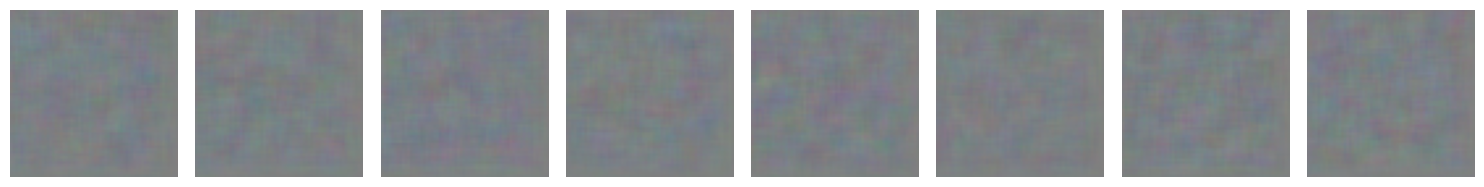

Time to Complete: 1.1345798969268799
------------------------------
Training Epoch: 3


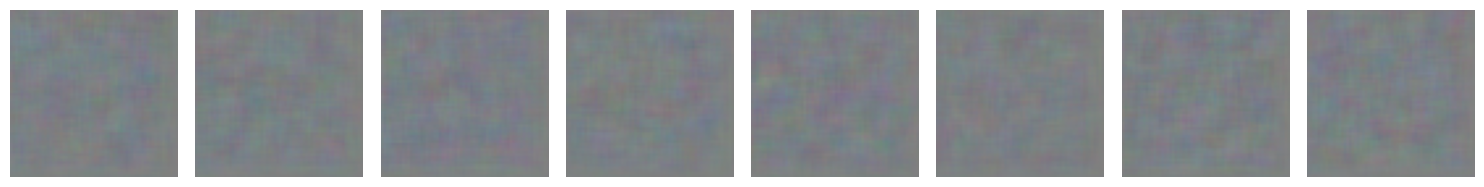

Time to Complete: 1.1337237358093262
------------------------------
Training Epoch: 4


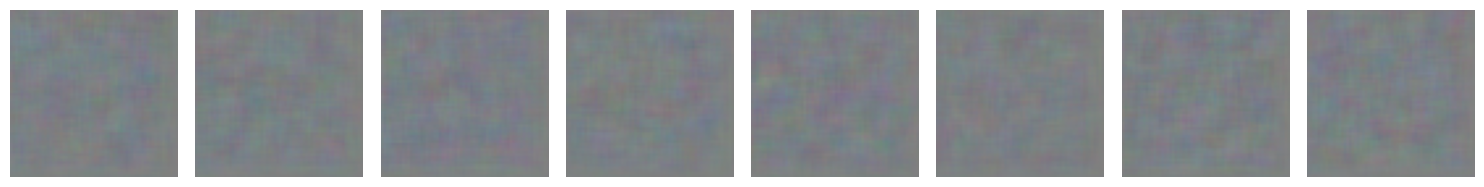

Time to Complete: 1.4385077953338623


In [ ]:
if TRAIN:
    train_GAN(
        dataset_train,
        epochs=EPOCHS,
        img_seed=SEED,
        checkpoint_path=CHECKPOINT_PATH,
        checkpoint=CHECKPOINT
    )
else:
    CHECKPOINT.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))

    noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim[0])).astype('float32')
    fake_x = gen.predict(noise)
    show_images(fake_x[:8])

In [ ]:
dataset_train.take(0)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Helper function


In [ ]:
def plot_history(model, title):
    # plot 'Loss'
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(model.history.history['loss'], label='train')
    axs[0].plot(model.history.history['val_loss'], label='validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Cross-Entropy Loss')
    best_loss = np.nanmin(model.history.history['val_loss'])
    axs[0].axvline(np.nanargmin(model.history.history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    axs[0].legend()
    axs[0].set_title(f'Training and Validation Loss - {title}')

    # in case the Network has multiple outputs
    train_accuracy = []
    val_accuracy = []

    for cur_history in model.history.history:
        if 'accuracy'in cur_history:
            if 'val' in cur_history:
                val_accuracy.append(model.history.history[cur_history])
            else:
                train_accuracy.append(model.history.history[cur_history])

    train_accuracy = np.mean(np.array(train_accuracy), axis=0)
    val_accuracy = np.mean(np.array(val_accuracy), axis = 0)

    # plot 'Accuracy'
    axs[1].plot(train_accuracy, label='train')
    axs[1].plot(val_accuracy, label='validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    best_accuracy = np.nanmax(val_accuracy)
    axs[1].axvline(np.nanargmax(val_accuracy),
                c='k', ls='--',
                label=f'best val accuracy = {best_accuracy:.5f}')
    axs[1].legend()
    axs[1].set_title(f'Training and Validation Accuracy - {title}')
    plt.tight_layout()

In [ ]:
def plot_model_result(model_name,history):
    """Visualize the training loss and accuracy"""
    # Plot the training and validation loss
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    ax = ax.ravel()
    plt.sca(ax[0])
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    # plt.xticks(np.arange(10), np.arange(1,11))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy - {model_name}')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    # plt.xticks(np.arange(10), np.arange(1,11))
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'Training and Validation Loss - {model_name}')
    plt.legend()
    plt.tight_layout()

In [ ]:
def plot_f1_score(model_name, f1_scores):
    f1_scores_dict = {label: score for label, score in zip(labels, f1_scores)}
    plt.subplots(figsize=(8,5), dpi =100)
    plt.bar(list(f1_scores_dict.keys()), list(f1_scores_dict.values()))
    for i in range(4):
        plt.text(i, f1_scores[i]/3,
              str(np.round(f1_scores[i], 4))+'\n',
              ha='center', va='bottom', color='white', weight='bold', fontsize = 18)
    plt.xlabel('Label')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score for Different Categories-{model_name}')
    plt.tight_layout()

In [ ]:
def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    y_label = np.array(y_label).ravel()
    y_pred = np.array(y_pred).ravel()

    classes = np.unique(y_label)
    cm = np.zeros((len(classes), len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            cm[i, j] = np.sum((y_pred == classes[i]) & (y_label == classes[j]))

    cm_percentage =  cm / np.sum(cm, axis=0)

    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    plt.imshow(cm_percentage.T, cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["predict-" + s[:1] for s in labels])
    plt.yticks(tick_marks, labels)

    for i in range(len(classes)):
        for j in range(len(classes)):
            num_items = cm[i, j]
            pct_items = cm_percentage[i, j]
            plt.text(i, j,  f'{pct_items*100:.2f}% \n {num_items} ', ha="center", va="center",
                     color="white" if  cm_percentage[i, j] > 0.6 else "black")
    plt.tight_layout()

# Build model

## Simple CNN

In [ ]:
model = Sequential(name="Simple_CNN")
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Model: "Simple_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dropout (Dropout)           (None, 115200)            0

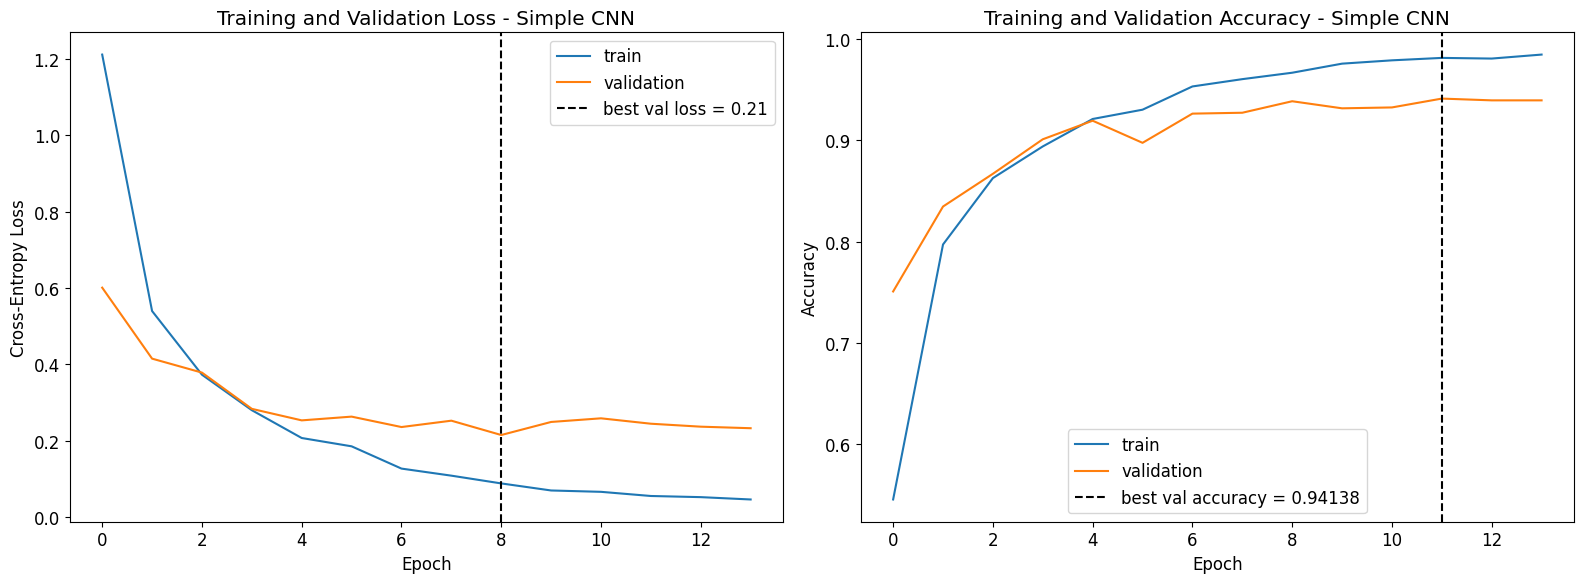

In [ ]:
plot_history(model, "Simple CNN")

In [ ]:
train_loss, train_acc = model.evaluate(dataset_train)
test_loss, test_acc = model.evaluate(dataset_test)
print(f'The train accuracy is {train_acc}')
print(f'The test accuracy is {test_acc}')

11/11 [==============================] - 1s 85ms/step - loss: 0.2137 - accuracy: 0.9375
The train accuracy is 0.9986867904663086
The test accuracy is 0.9374523162841797


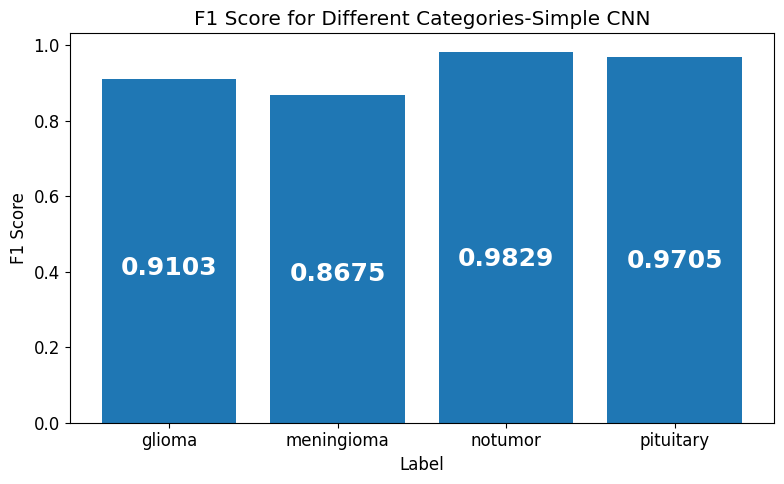

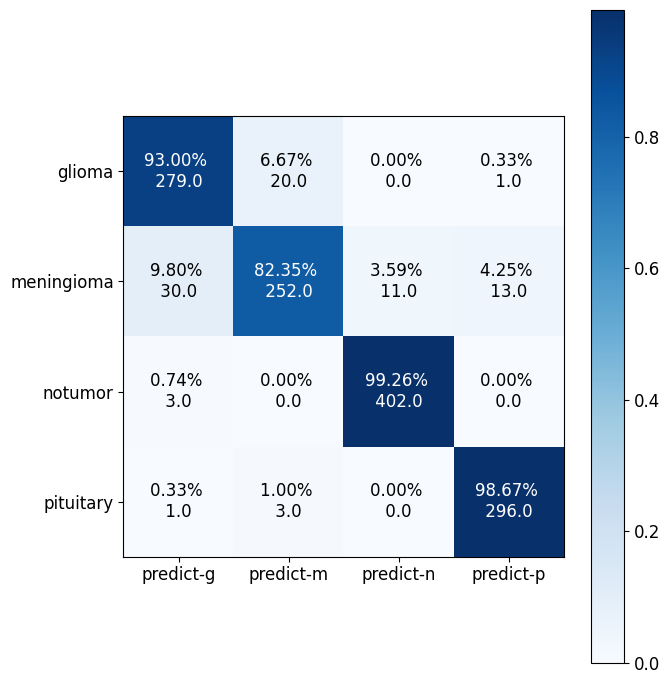

In [ ]:
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("Simple CNN", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

## Vgg 16

In [ ]:
vgg16_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in vgg16_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
vgg16_model.layers[-2].trainable = True
vgg16_model.layers[-3].trainable = True
vgg16_model.layers[-4].trainable = True

model = Sequential(name="vgg_16")
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(vgg16_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                             

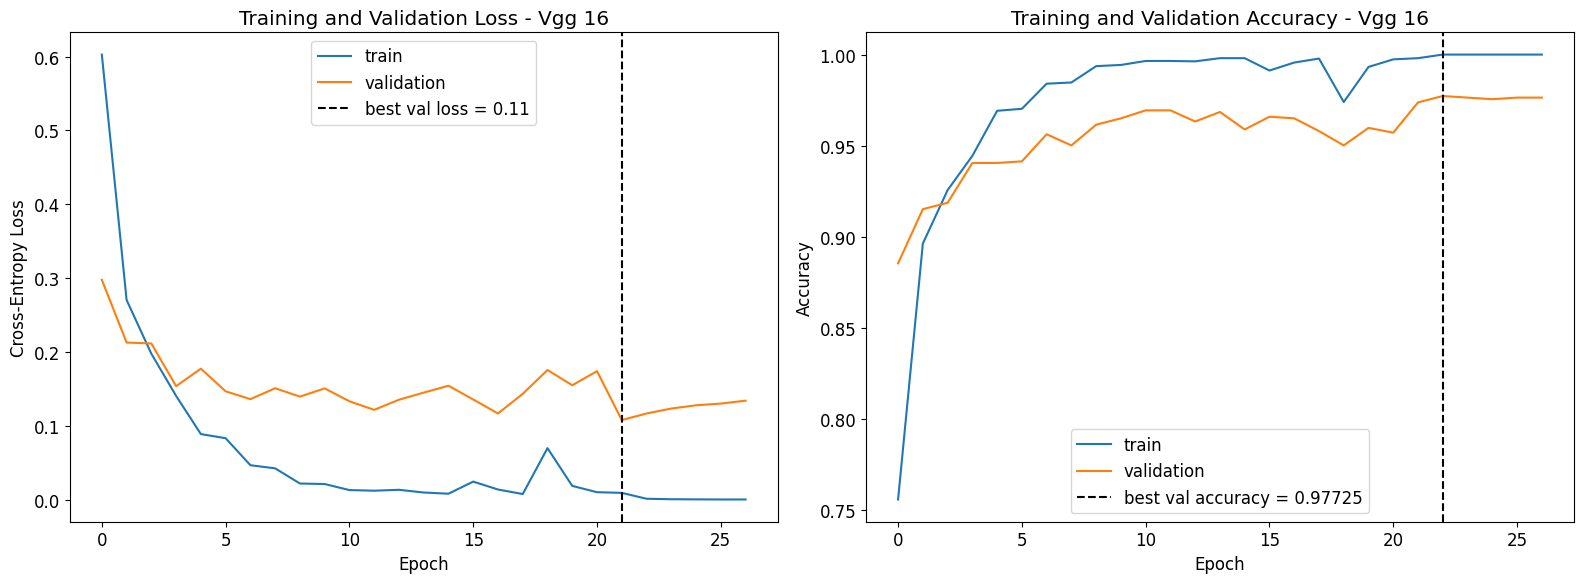

In [ ]:
plot_history(model, "Vgg 16")

In [ ]:
train_loss, train_acc = model.evaluate(dataset_train)
test_loss, test_acc = model.evaluate(dataset_test)
print(f'The train accuracy is {train_acc}')
print(f'The test accuracy is {test_acc}')

11/11 [==============================] - 4s 333ms/step - loss: 0.1244 - accuracy: 0.9710
The train accuracy is 1.0
The test accuracy is 0.9710144996643066


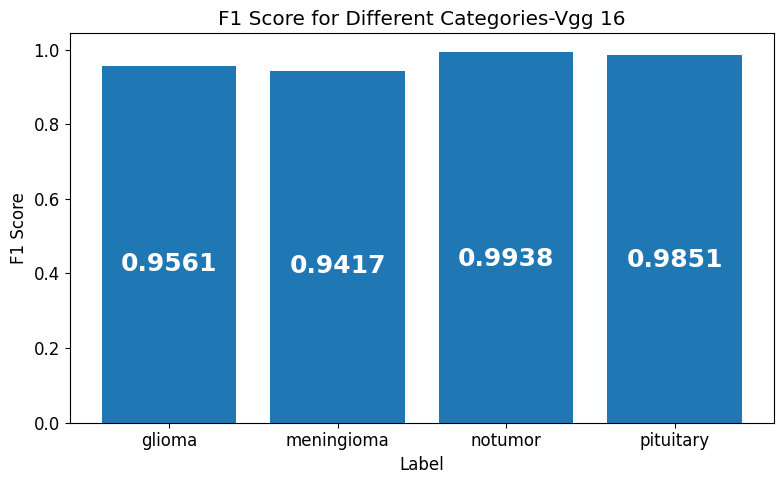

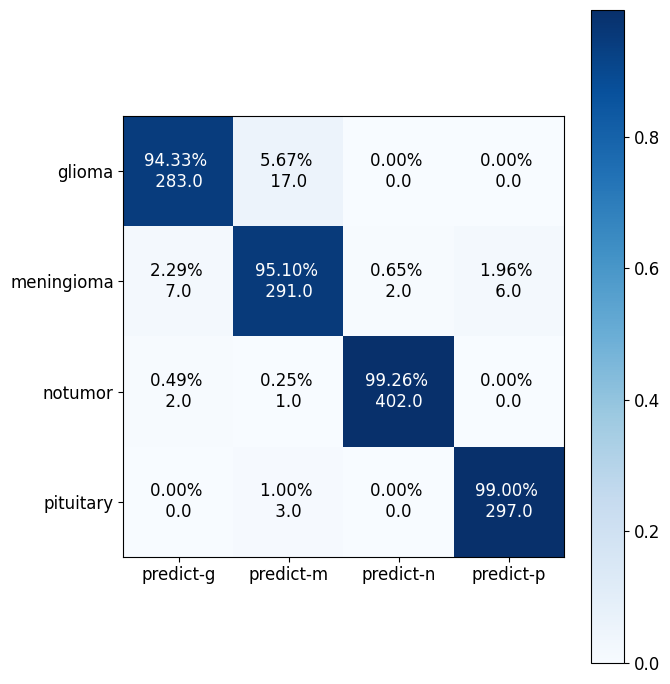

In [ ]:
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("Vgg 16", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

## ResNet 50

In [ ]:
resnet50_model = ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in resnet50_model.layers:
    layer.trainable = False
# Set the last resnet block to trainable
resnet50_model.layers[-2].trainable = True
resnet50_model.layers[-3].trainable = True
resnet50_model.layers[-4].trainable = True

model = Sequential(name="ResNet50")
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(resnet50_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

94765736/94765736 [==============================] - 5s 0us/step
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_4 (Dropout)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                           

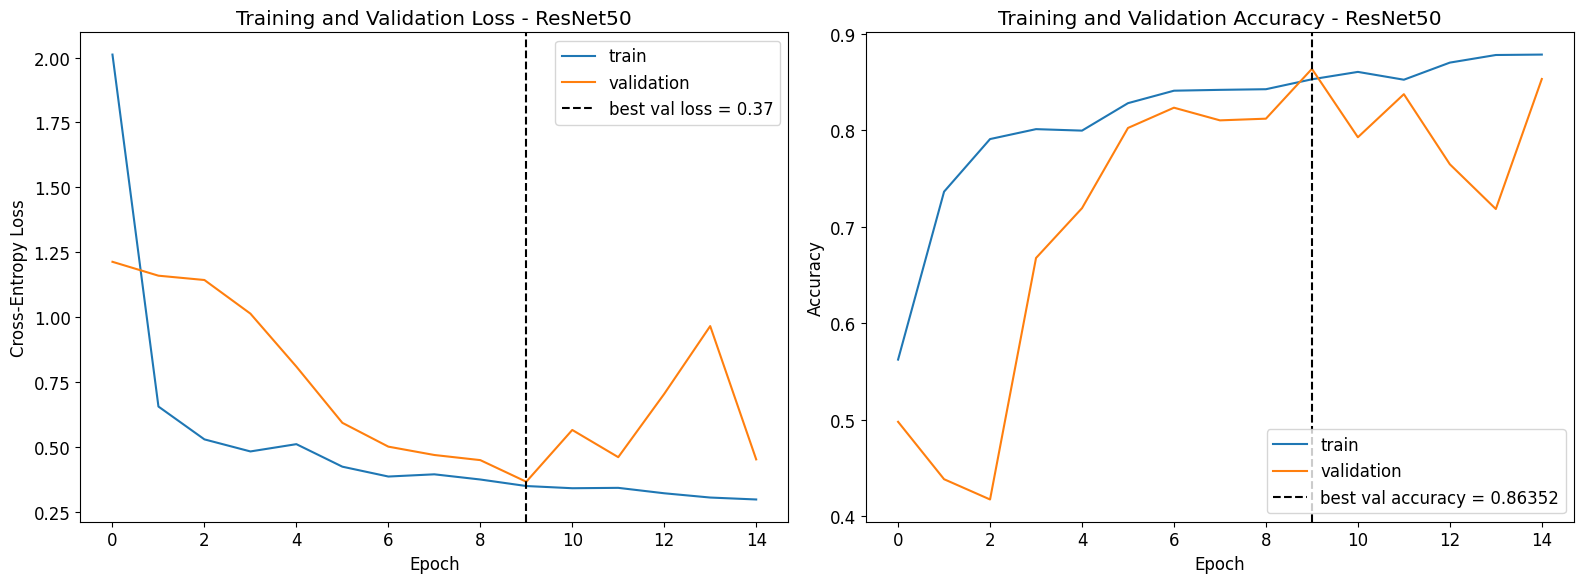

In [ ]:
plot_history(model, "ResNet50")

In [ ]:
train_loss, train_acc = model.evaluate(dataset_train)
test_loss, test_acc = model.evaluate(dataset_test)
print(f'The train accuracy is {train_acc}')
print(f'The test accuracy is {test_acc}')

11/11 [==============================] - 2s 174ms/step - loss: 0.5821 - accuracy: 0.8116
The train accuracy is 0.8726198077201843
The test accuracy is 0.8115941882133484


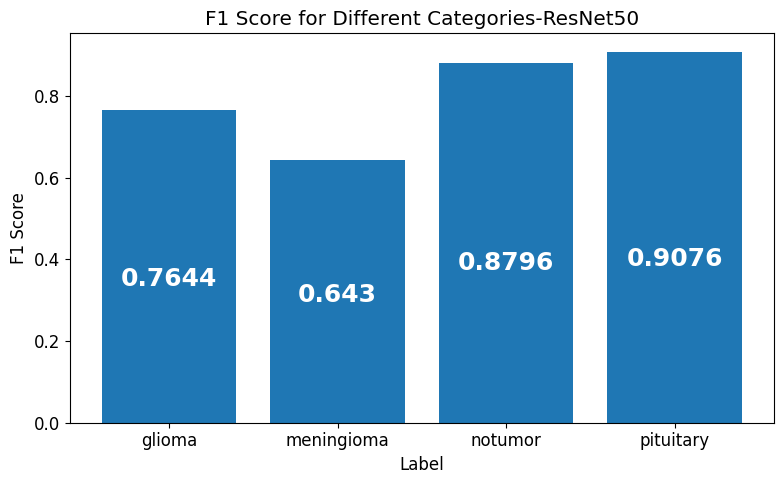

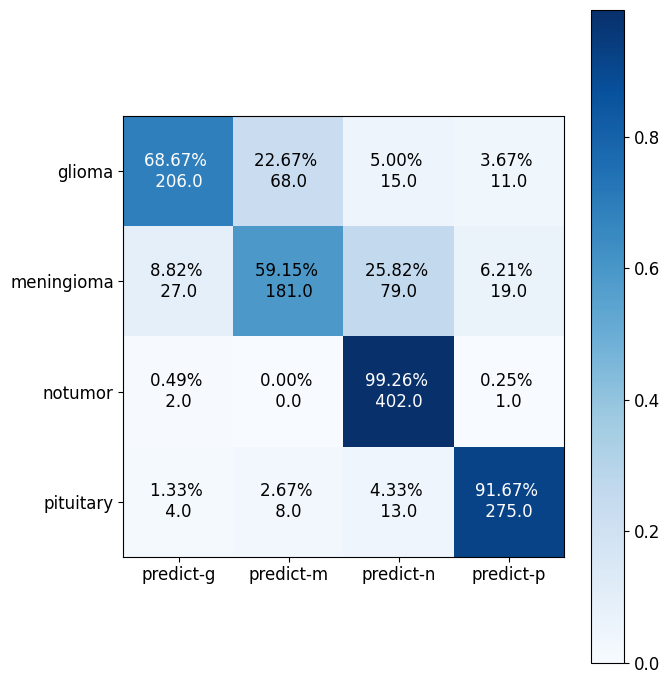

In [ ]:
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("ResNet50", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

## GoogleNet

In [ ]:
def inception_block(input_tensor, filters):
    # Branch 1
    branch1 = Conv2D(filters[0], (1,1), activation='relu')(input_tensor)

    # Branch 2
    branch2 = Conv2D(filters[1], (1,1), activation='relu')(input_tensor)
    branch2 = Conv2D(filters[2], (3,3), padding='same', activation='relu')(branch2)

    # Branch 3
    branch3 = Conv2D(filters[3], (1,1), activation='relu')(input_tensor)
    branch3 = Conv2D(filters[4], (5,5), padding='same', activation='relu')(branch3)

    # Branch 4
    branch4 = MaxPool2D((3,3), strides=(1,1), padding='same')(input_tensor)
    branch4 = Conv2D(filters[5], (1,1), activation='relu')(branch4)

    # Concatenate branches
    output_tensor = concatenate([branch1, branch2, branch3, branch4], axis=-1)

    return output_tensor

In [ ]:
def auxiliary_block(input_tensor, aux_name):
    X = AveragePooling2D(pool_size = (5,5), strides = (3,3), padding='same')(input_tensor)
    X = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X)
    X = Flatten()(X)
    X = Dense(1024, activation = 'relu')(X)
    X = Dropout(0.7)(X)
    output_tensor = Dense(4, activation = 'softmax', name = aux_name)(X)

    return output_tensor

In [ ]:
def GoogleNet(input_shape):
    inp = Input(shape=input_shape)

    X = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(inp)
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)
    X = Conv2D(64, (1,1), activation='relu')(X)
    X = Conv2D(192, (3,3), padding='same', activation='relu')(X)
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)

    # First Inception blocks (x2)
    X = inception_block(X, [64, 96, 128, 16, 32, 32])
    X = inception_block(X, [128, 128, 192, 32, 96, 64])
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)

    # Second Inception blocks (x5)
    X = inception_block(X, [192, 96, 208, 16, 48, 64])
    X = inception_block(X, [160, 112, 224, 24, 64, 64])
    X1 = auxiliary_block(X, aux_name = 'aux_output1') # First Auxiliary block

    X = inception_block(X, [128, 128, 256, 24, 64, 64])
    X = inception_block(X, [112, 144, 288, 32, 64, 64])
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    X2 = auxiliary_block(X, aux_name = 'aux_output2') # Second Auxiliary block

    # Third Inception blocks (x2)
    X = MaxPool2D((3,3), strides=(2,2), padding='same')(X)
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    X = inception_block(X, [384, 192, 384, 48, 128, 128])
    X = GlobalAvgPool2D()(X)
    X = Dense(4, activation='softmax', name='main_output')(X)
    model = Model(inputs=inp, outputs=[X, X1, X2])

    return model

In [ ]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = GoogleNet(input_shape)

# plot model architecture
keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())
# fit model
history = model.fit(dataset_train, epochs=50, batch_size=256,
                   validation_data = dataset_val, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 64)  0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 64)   4160        ['max_pooling2d_2[0][0]']    

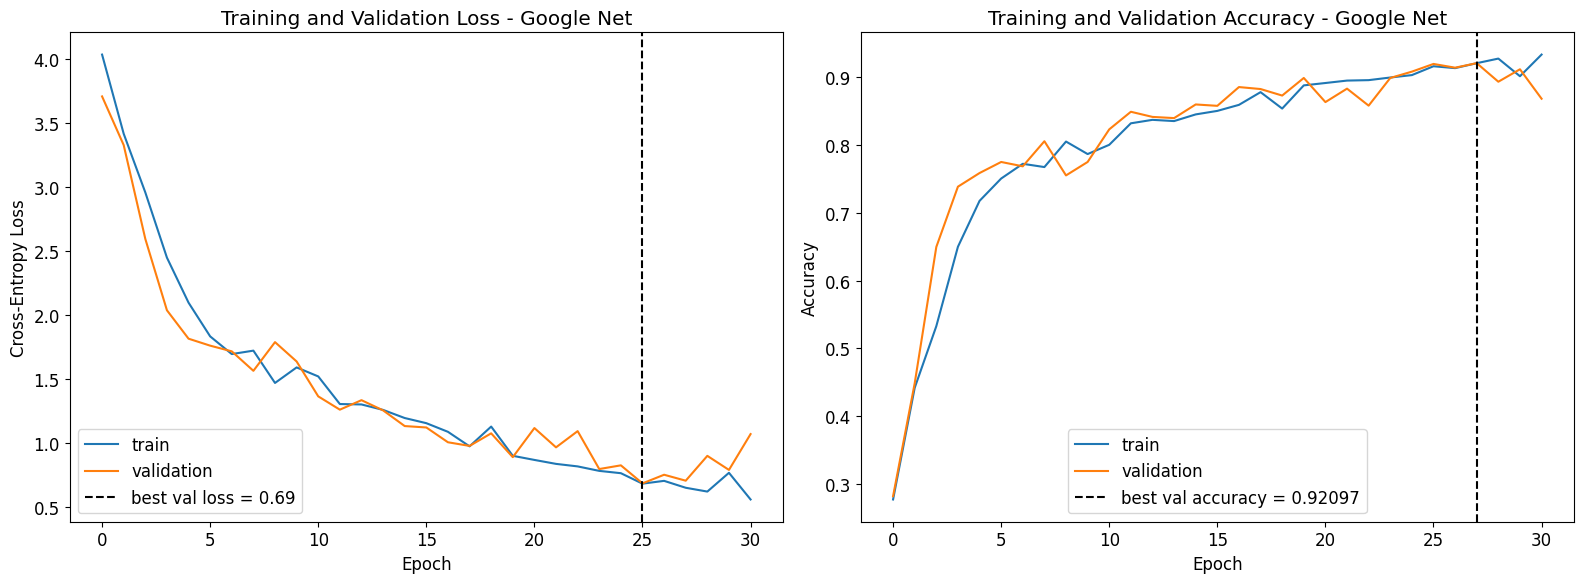

In [ ]:
plot_history(model, "Google Net")

In [ ]:
result = model.evaluate(dataset_train, verbose=0)
if len(model.metrics_names) > 2:
    test_loss_idx = model.metrics_names.index('main_output_loss')
    test_accuracy_idx = model.metrics_names.index('main_output_accuracy')
    test_loss, test_accuracy = result[test_loss_idx], result[test_accuracy_idx]
else:
    test_loss, test_accuracy = result

print('The train accuracy is:', round(test_accuracy, 3))

result = model.evaluate(dataset_test, verbose=0)
if len(model.metrics_names) > 2:
    test_loss_idx = model.metrics_names.index('main_output_loss')
    test_accuracy_idx = model.metrics_names.index('main_output_accuracy')
    test_loss, test_accuracy = result[test_loss_idx], result[test_accuracy_idx]
else:
    test_loss, test_accuracy = result

print('The test accuracy is:', round(test_accuracy, 3))

The train accuracy is: 0.894
The test accuracy is: 0.842


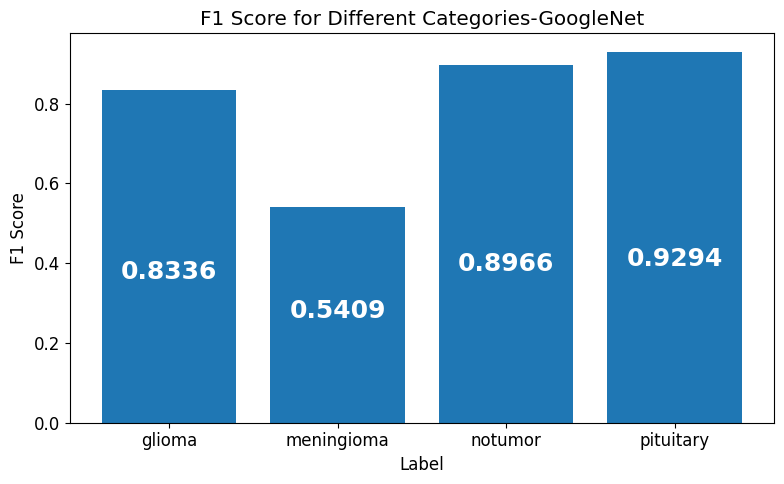

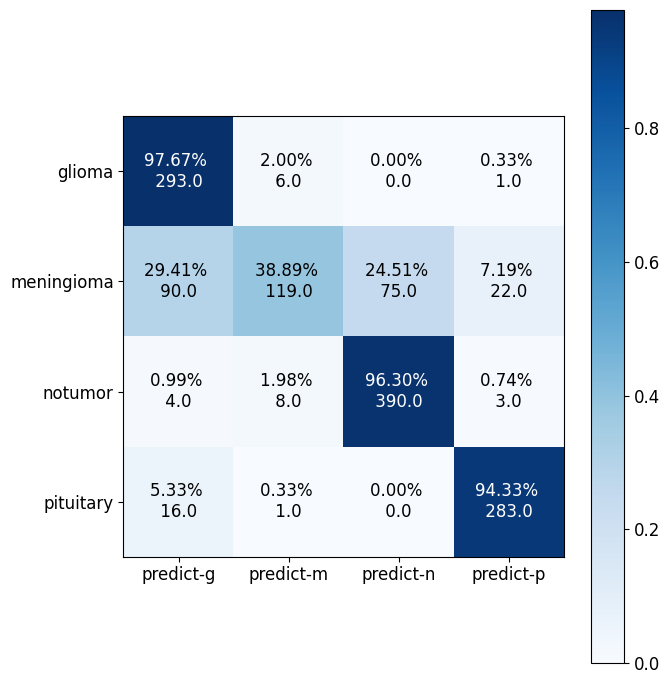

In [ ]:
y_prob = model.predict(X_test, verbose=0)[1]
y_pred = np.argmax(y_prob, axis=-1)
f1_scores = f1_score(y_test.ravel(), y_pred.ravel(), average=None)

# plot f1 score
plot_f1_score("GoogleNet", f1_scores)
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred)